- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/474 : staratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
from pytorchtools.pytorchtools import EarlyStopping # 현재 폴더에 추가된 모듈.
import torchvision.models as models




if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.0  Device :  cuda


# SVD 문장 데이터에서 Feature 추출
- mfcc

In [2]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

In [12]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

pathology_sig=[]
healthy_sig=[]

pathology=[]
healthy=[]


#PATHOLOGY DATA
for audio_path in os.listdir('../voice_data/disorder/export/'):
    sig, sr = librosa.load('../voice_data/disorder/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    pathology_sig.append(sig)
    MFCCs = librosa.feature.mfcc(sig, sr, win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
    pathology.append(MFCCs)
    

#Healthy data
for audio_path in os.listdir('../voice_data/healthy/export/'):
    sig, sr = librosa.load('../voice_data/healthy/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    healthy_sig.append(sig)
    MFCCs = librosa.feature.mfcc(sig, sr, win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
    healthy.append(MFCCs)
    
print("pathology data 수 : ",len(pathology))
print("healthy data 수 : ",len(healthy))


path_max=max([ len(samples) for samples in pathology_sig])
healthy_max=max([ len(samples) for samples in healthy_sig])
print("가장 긴 path sample :" ,path_max)
print("가장 긴 healthy sample :" ,healthy_max)

pathology data 수 :  852
healthy data 수 :  632
가장 긴 path sample : 317967
가장 긴 healthy sample : 207017


In [4]:
print(path_max/sr,"초")
print(healthy_max/sr,"초")

6.35934 초
4.14034 초


array([[-664.5546   , -661.09326  , -648.41675  , ..., -583.1954   ,
        -591.54895  , -598.0238   ],
       [  42.987347 ,   49.232384 ,   59.7008   , ...,  100.61284  ,
          96.951584 ,   90.819595 ],
       [  19.686474 ,   25.329206 ,   29.251112 , ...,   25.392967 ,
          27.55801  ,   32.691036 ],
       ...,
       [   5.0496755,    5.7428827,    3.4806967, ...,   18.50998  ,
           5.907953 ,    8.640621 ],
       [   9.790856 ,   12.660656 ,    4.9854956, ...,    5.336875 ,
           2.23176  ,    4.5691023],
       [  18.775772 ,   19.052063 ,    9.2463875, ...,    2.3773415,
           2.4097412,   10.659433 ]], dtype=float32)

# 결과 확인
- 1 row당 1 frame으로

In [30]:
len(healthy[0][2]) #1번 : 파일. 2번:mfcc
headers = "mfcc1 mfcc2 mfcc3 mfcc4 mfcc5 mfcc6 mfcc7 mfcc8 mfcc9 mfcc10 mfcc11 mfcc12 mfcc13".split()
pd.DataFrame(healthy[0].T,columns=headers)



,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13
0,-277.435181,217.131302,-13.972048,2.421658,-46.796097,-4.302108,-28.972664,13.408556,28.633501,-23.682468,-10.976597,5.232002,-27.321705
1,-281.919495,210.899353,-14.512285,-0.058138,-50.630947,-8.609697,-39.469994,9.049422,23.882133,-24.983570,-13.507469,8.224895,-22.392838
2,-307.412170,182.036957,-23.609758,-1.286402,-46.687546,-8.553607,-44.500671,9.419307,23.425653,-21.788742,-17.821304,14.514274,-17.257675
3,-308.061707,185.260468,-20.746826,-2.282940,-47.517494,-8.603182,-44.703972,8.796711,28.302505,-13.937325,-18.596596,12.981836,-14.991493
4,-312.488892,183.100967,-23.440123,-1.653871,-47.008690,-9.748432,-45.852364,5.705857,24.955027,-18.747026,-19.271517,9.628666,-14.358886
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,-312.916199,158.961182,-26.786573,13.924356,-51.417900,-6.173113,-41.896027,7.595150,21.323551,-27.307755,-14.366621,14.418139,-21.696594
308,-311.370911,161.326279,-22.441750,14.180597,-55.980904,-7.803135,-41.668770,11.216280,24.795391,-24.515268,-12.940067,13.673044,-19.685993
309,-316.772736,164.728607,-26.624262,11.242275,-57.082973,-11.883168,-40.423569,10.203865,23.440647,-26.331760,-14.870211,11.893984,-15.572662
310,-300.903534,186.152023,-21.547771,9.273628,-56.856239,-14.139202,-39.882935,4.801795,20.053015,-23.554581,-13.533127,12.452017,-12.816125


In [17]:
healthy[0].shape[1]

326

In [5]:
del pathology
del healthy
del pathology_sig
del healthy_sig

# 데이터 나누기  (validation 포함.)
- 22.01.05
- 0.5 비율로 healthy, pathology 샘플 분배. 

- pathology : (852) -> 632 , healthy 수 : 632 총 1264
- train : 1011 , validation:126 , test : 127


In [3]:
#1. train, test 나누기
import os
import random #데이터 shuffle 사용
from glob import glob


pathology = glob('../voice_data/disorder/export/*.wav')
healthy = glob('../voice_data/healthy/export/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

random.seed(123)
random.shuffle(pathology)

pathology=pathology[:632]

X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = {} # 라벨
for idx,x in enumerate(X):
    if idx<632:
        Y[x]="pathology"
    else:
        Y[x]="healthy"

#train 1011   test: 253
random.seed(123)
random.shuffle(X)
DATA_TRAINING_PATH = X[:1011]
DATA_VALIDATION_PATH = X[1011:1137]
DATA_TEST_PATH = X[1137:]

print("훈련 셋 : ",len(DATA_TRAINING_PATH))
print("검증 셋 : ",len(DATA_VALIDATION_PATH))
print("테스트 셋 : ",len(DATA_TEST_PATH))

Pathology :  852
Healthy:  632
총 데이터수 :  1264
훈련 셋 :  1011
검증 셋 :  126
테스트 셋 :  127


In [4]:
print(len(Y))

1264


In [5]:
#train test set 비율

train_all = [Y[path] for path in DATA_TRAINING_PATH]
validation_all = [Y[path] for path in DATA_VALIDATION_PATH]
test_all  = [Y[path] for path in DATA_TEST_PATH]
print("\n")
print('[Train-set]\t pathology : ',train_all.count('pathology')," healthy: ",train_all.count('healthy'),' path 비율: {:.4f}'.format(train_all.count('pathology')/len(train_all)) )
print('[Validation-set]\t pathology : ',validation_all.count('pathology')," healthy: ",validation_all.count('healthy'),' path 비율: {:.4f}'.format(validation_all.count('pathology')/len(validation_all)) )
print('[Test-set]\t pathology : ',test_all.count('pathology')," healthy: ",test_all.count('healthy'),' path 비율: {:.4f}'.format(test_all.count('pathology')/len(test_all)) )





[Train-set]	 pathology :  519  healthy:  492  path 비율: 0.5134
[Validation-set]	 pathology :  56  healthy:  70  path 비율: 0.4444
[Test-set]	 pathology :  57  healthy:  70  path 비율: 0.4488


# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.


In [55]:
from torch.utils.data import Dataset, DataLoader

classes = ["pathology","healthy"]
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        self.path_list = data_path_list
        self.label = svd_dataset.get_label(data_path_list)
        self.classes=classes
        self.transform=transform
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        for idx in data_path_list:
            label_list.append(Y[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 500프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        
        sig, sr = librosa.load(self.path_list[idx], sr=50000)# 논문에서 f_s = 50 000HZ
        
        MFCCs = librosa.feature.mfcc(sig, sr, win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
        #mfcc 400 FRAME이 되도록 패딩.
        length = 500
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        MFCCs = pad2d(MFCCs, length)
        MFCCs= MFCCs.T
        
        if self.transform:
            #print('transform')
            MFCCs=self.transform(MFCCs).type(torch.float32)# 데이터 0~1 정규화
            MFCCs=torch.stack([MFCCs,MFCCs,MFCCs])# 3채널로 복사.
            MFCCs = MFCCs.squeeze(dim=1)
        else:
            #print("else")
            MFCCs = torch.from_numpy(MFCCs).type(torch.float32)
            MFCCs=MFCCs.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MFCCs, self.classes.index(self.label[idx])
    

# 데이터 로더

In [56]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개 음성데이터
EPOCHS = 40 # 전체 데이터 셋을 50번 반복

In [57]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.
train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               DATA_TRAINING_PATH,
                                               classes,
                                               transform = transforms.ToTensor()#이걸 composed로 고쳐서 전처리 하도록 수정.
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               DATA_VALIDATION_PATH,
                                               classes,
                                               transform = transforms.ToTensor()
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,) 


test_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               DATA_TEST_PATH,
                                               classes,
                                               transform = transforms.ToTensor()
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,) 



# 데이터 확인

X_train :  torch.Size([32, 3, 500, 13]) type: torch.FloatTensor
Y_train :  torch.Size([32]) type: torch.LongTensor
tensor(0)


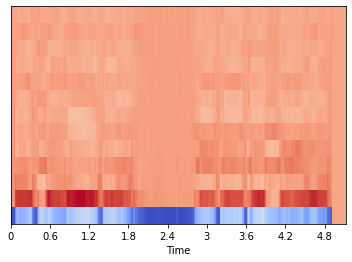

In [60]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
librosa.display.specshow(X_train[0][0].numpy().T, sr=50000, x_axis='time')
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([32, 3, 500, 13]) type: torch.FloatTensor
Y_valid :  torch.Size([32]) type: torch.LongTensor
tensor(0)


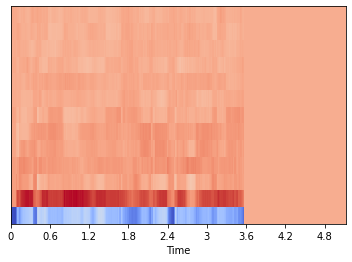

In [61]:
#valiation set 확인
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0])
librosa.display.specshow(X_valid[0][0].numpy().T, sr=50000, x_axis='time')
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# RESNET

In [110]:
# 모델 1
model = models.resnet34(pretrained=False).cuda()
model.ftrs = model.fc.in_features # in_features : fully connected의 입력수.
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # 두가지 클래스

model = model.cuda()



In [ ]:
# 모델 2
model = models.resnet34(pretrained=False).cuda()
model.ftrs = model.fc.in_features # in_features : fully connected의 입력수.
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
              nn.BatchNorm1d(256),
              nn.Linear(256, 2))

model = model.cuda()



In [111]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [112]:
# get the model summary
from torchsummary import summary
summary(model, input_size=(3, 500, 13), device=DEVICE.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 250, 7]           9,408
       BatchNorm2d-2           [-1, 64, 250, 7]             128
              ReLU-3           [-1, 64, 250, 7]               0
         MaxPool2d-4           [-1, 64, 125, 4]               0
            Conv2d-5           [-1, 64, 125, 4]          36,864
       BatchNorm2d-6           [-1, 64, 125, 4]             128
              ReLU-7           [-1, 64, 125, 4]               0
            Conv2d-8           [-1, 64, 125, 4]          36,864
       BatchNorm2d-9           [-1, 64, 125, 4]             128
             ReLU-10           [-1, 64, 125, 4]               0
       BasicBlock-11           [-1, 64, 125, 4]               0
           Conv2d-12           [-1, 64, 125, 4]          36,864
      BatchNorm2d-13           [-1, 64, 125, 4]             128
             ReLU-14           [-1, 64,

In [113]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [114]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(test_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [115]:
#10. 학습 및 평가.
# resnet

train_losses = [] # epoch별 평균 loss가 담긴다. 시각화에 사용.
valid_losses = []

train_accs = []
valid_accs = []

early_stopping = EarlyStopping(patience = 5, verbose = True, path='./checkpoint/checkpoint_resnet.pt')


for Epoch in range(1,EPOCHS+1):
    train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
    valid_loss,valid_accuracy = evaluate(model, validation_loader)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_accuracy)
    valid_accs.append(valid_accuracy)
    
    print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
          format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))

    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
            print("Early stopping")
            break

model.load_state_dict(torch.load('./checkpoint/checkpoint_resnet.pt'))


[EPOCH:1]	 Train Loss:0.0185	 Train Acc:70.43 %  | 	Valid Loss:0.0181 	Valid Acc: 66.67 %

Validation loss decreased (inf --> 0.018108).  Saving model ...

[EPOCH:2]	 Train Loss:0.0150	 Train Acc:77.74 %  | 	Valid Loss:0.0242 	Valid Acc: 65.87 %

EarlyStopping counter: 1 out of 5

[EPOCH:3]	 Train Loss:0.0125	 Train Acc:82.69 %  | 	Valid Loss:0.0167 	Valid Acc: 74.60 %

Validation loss decreased (0.018108 --> 0.016700).  Saving model ...

[EPOCH:4]	 Train Loss:0.0091	 Train Acc:88.63 %  | 	Valid Loss:0.0275 	Valid Acc: 74.60 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0086	 Train Acc:88.13 %  | 	Valid Loss:0.0196 	Valid Acc: 74.60 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train Loss:0.0063	 Train Acc:91.79 %  | 	Valid Loss:0.0241 	Valid Acc: 73.81 %

EarlyStopping counter: 3 out of 5

[EPOCH:7]	 Train Loss:0.0039	 Train Acc:95.05 %  | 	Valid Loss:0.0815 	Valid Acc: 56.35 %

EarlyStopping counter: 4 out of 5

[EPOCH:8]	 Train Loss:0.0045	 Train Acc:93.67 %  | 	

<All keys matched successfully>

# Model Test

- test set
- confusion matrix

In [121]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [122]:
# Confusion matrix (resnet34)
model.load_state_dict(torch.load('./checkpoint/checkpoint_resnet.pt'))

predictions,answers,test_loss = test_evaluate(model, test_loader)
predictions=[ dat.cpu().numpy() for dat in predictions]
answers=[ dat.cpu().numpy() for dat in answers]

from sklearn.metrics import confusion_matrix
cf = confusion_matrix(answers, predictions)
print(cf)

test_loss_mean = test_loss/len(test_loader.dataset)
acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
precision=cf[0,0]/(cf[0,0]+cf[1,0])
recall=cf[0,0]/(cf[0,0]+cf[0,1])
fscore=2*precision*recall/(precision+recall)


print("Test Loss : {:.4f}".format(test_loss_mean))
print("Accuracy : {:.4f}% ".format(acc*100))
print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
print("f score : {:.4f} ".format(fscore))


[[30 27]
 [11 59]]
Test Loss : 0.0186
Accuracy : 70.0787% 
Precision (pathology 예측한 것중 맞는 것) : 0.7317
recall (실제 pathology 중  예측이 맞는 것) : 0.5263
f score : 0.6122 


# Loss 시각화

In [116]:
len([ a for a in range(1,len(train_losses)) ])

7

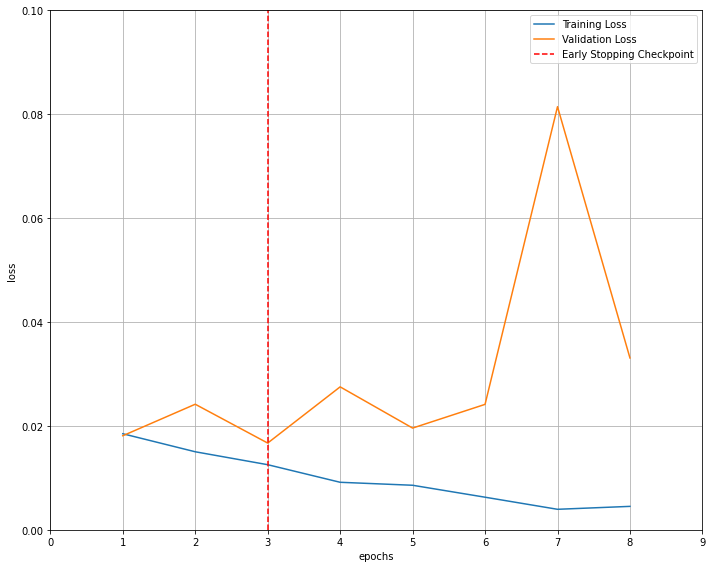

In [120]:
#일반 cnn loss 시각화
#훈련이 진행되는 과정에 따라 loss를 시각화

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1 ),train_losses,label='Training Loss')
plt.plot(range(1,len(valid_losses)+1 ),valid_losses,label='Validation Loss')

#validation loss의 최저값 지점
minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs,linestyle='--',color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')

plt.ylim(0.0,0.1)# 일정한 scale
plt.xlim(0,len(train_losses)+1) # 일정 sclae로

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('cnn_loss_flot.png',bbox_inches='tight')


# Accuracy 시각화

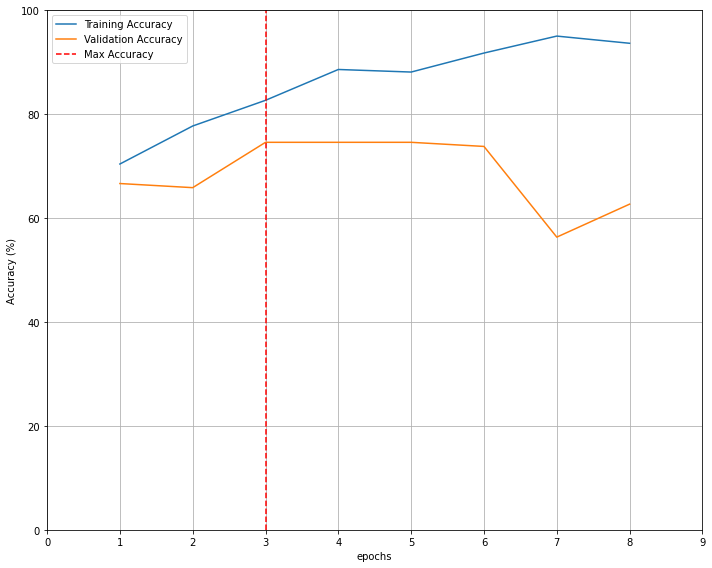

In [118]:
#일반 cnn loss 시각화
#훈련이 진행되는 과정에 따라 loss를 시각화

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_accs)+1 ),train_accs,label='Training Accuracy')
plt.plot(range(1,len(valid_accs)+1 ),valid_accs,label='Validation Accuracy')

#validation loss의 최저값 지점
minposs = valid_accs.index(max(valid_accs))+1
plt.axvline(minposs,linestyle='--',color='r',label='Max Accuracy')

plt.xlabel('epochs')
plt.ylabel('Accuracy (%)')

plt.ylim(0,100.0)# 일정한 scale
plt.xlim(0,len(train_accs)+1) # 일정 sclae로

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('cnn_loss_flot.png',bbox_inches='tight')


# 기타

In [17]:
#크기 알아보기
#일반 CNN

m = nn.MaxPool2d(2, stride=2)
#m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(32, 1, 500, 13)
print(input.size())
output = m(input)
print(output.size())
output = m(output)
print(output.size())

torch.Size([32, 1, 500, 13])
torch.Size([32, 1, 250, 6])
torch.Size([32, 1, 125, 3])


In [16]:
#크기 알아보기
#주파수 영역 CNN

input = torch.randn(32, 1, 500, 13)
m=nn.Conv2d(
            in_channels = 1,# 채널이 1개
            out_channels = 32,# FeatureMap 수,커널 수
            kernel_size = (1,13),#1x13  no padding
        )
output=m(input)
print(output.size())
m=nn.Conv2d(
            in_channels = 32,# 채널이 1개
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = (27,1),#9 x 1 no padding
        )
output=m(output)
print(output.size())


torch.Size([32, 32, 500, 1])
torch.Size([32, 64, 474, 1])


In [16]:
input = torch.randn(500, 13)

out=torch.stack([input,input,input])
out.size()

torch.Size([3, 500, 13])

In [ ]:
test_model = 